### In this notebook, we implement the pytorch version of ANNz.
    This is a full example demonstated with SDSS data.
    Our goal is to train the NN learn the pattern from [multiband-photometry] -> [redshfit z]

In [ ]:
from astropy.table import Table, hstack, vstack #astropy is used
from astropy.io import fits
import numpy as np
from scipy.stats import pearsonr

import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset



#specific for SDSS data
#Trainning, test, validation dataset are sepereated to different files

#read training set
data = Table.read('../example_data/sdss/sdss.ugriz.train', format = 'ascii')
input_data_x = np.array(data['col1', 'col2','col3','col4','col5'].to_pandas()) #ugriz photometry, from ANNz readme
input_data_y = np.array(data['col11']).astype('float64') #redshift


data_val = Table.read('../example_data/sdss/sdss.ugriz.train', format = 'ascii')
input_data_x_val = np.array(data_val['col1', 'col2','col3','col4','col5'].to_pandas()) #ugriz photometry, from ANNz readme
input_data_y_val = np.array(data_val['col11']).astype('float64') #redshift


In [43]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
#examine the input data first
import sys
sys.path.append('../src')

from evaluate_input_data import test_correlation, show_stats

#calcualte the pearson scores >0.5 is considered correlated
test_correlation(input_data_x, input_data_y)

#show mean, min, max, std
show_stats(input_data_x, input_data_y)

#from the report, our x and y are correlated, where X need normalization.


Feature 0: correlation = 0.8063, p-value = 0.0000e+00
Feature 1: correlation = 0.7815, p-value = 0.0000e+00
Feature 2: correlation = 0.6849, p-value = 0.0000e+00
Feature 3: correlation = 0.5410, p-value = 0.0000e+00
Feature 4: correlation = 0.5234, p-value = 0.0000e+00

Feature 0: mean: 19.597007435951998, min,max: (13.92700386, 34.04383087), std: 1.4713095289413356
Feature 1: mean: 17.884810839826002, min,max: (12.30952358, 36.46289444), std: 1.1523176350542608
Feature 2: mean: 16.940337153439998, min,max: (11.727458, 19.51945877), std: 0.875764240541404
Feature 3: mean: 16.520578818331998, min,max: (11.41958427, 35.74577332), std: 0.9112781318132575
Feature 4: mean: 16.230736427486, min,max: (11.15882397, 32.14431), std: 0.8597100415279613
input Y: mean: 0.13231408978, min,max: (0.00209463, 0.637909), std: 0.0946455296727628
⚠️ Input X range may lead to saturation for activation functions, Normalization recommended.


In [53]:
#Normalization
from norm_input import return_scaler, transform_val_or_test

#do not train scaler for each sample, use one x, one y scale for all sames 
x_training_scaled, scaler_x = return_scaler(input_data_x)
y_training_scaled, scaler_y = return_scaler(input_data_y)

x_train_tensor = torch.tensor(x_training_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_training_scaled, dtype=torch.float32).reshape(-1, 1) #y is 1D: (n,) shape

#do not fit a different scaler for validation or test
x_val_tensor = torch.tensor(transform_val_or_test(input_data_x_val,scaler_x ), dtype=torch.float32)
y_val_tensor = torch.tensor(transform_val_or_test(input_data_y_val, scaler_y), dtype=torch.float32).reshape(-1, 1)


In [ ]:
#create model

from model import create_model,WeightedMSELoss, train_model

#You could design the model yourself, here we create two models for the class project

def ANNz_original():

  # Create and train model
  model = create_model(
      input_dim=x_train_tensor.shape[1],  # 5
      hidden_size=10,
      output_dim=1,
      depth=2,
      activation='Sigmoid',

  )

  print(f"\nModel architecture:\n{model}")

  # Train
  losses, val_losses = train_model(
      model,
      x_train_tensor,
      y_train_tensor,
      epochs=1000, #following the paper
      lr=0.01,
      reg_type='l2',
      lambda_reg=0.0001,
      x_val = x_val_tensor,
      y_val = y_val_tensor
  )

  return model, losses, val_losses


def update_SDSS():

  # Create and train model
  model = create_model(
      input_dim=x_train_tensor.shape[1],  # 5
      hidden_size=16,
      output_dim=1,
      depth=3,
      activation='ReLU',

   )

  print(f"\nModel architecture:\n{model}")

  # Train
  losses, val_losses = train_model(
      model,
      x_train_tensor,
      y_train_tensor,
      epochs=1000, #following the paper
      lr=0.01,
      reg_type='l2',
      lambda_reg=0.01,
      x_val = x_val_tensor,
      y_val = y_val_tensor
  )

  return model, losses, val_losses


model_ANNz, losses_ANNz, val_losses_ANNz = ANNz_original()
model_update_SDSS, losses_update_SDSS, val_losses_update_SDSS = update_SDSS()



Model architecture:
Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=10, out_features=1, bias=True)
)


Training: 100%|██████████| 1000/1000 [00:01<00:00, 901.01it/s, Train=0.076230, Val=0.073294, Best=0.073294, Patience=0/1000]



Model architecture:
Sequential(
  (0): Linear(in_features=5, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=1, bias=True)
)


Training: 100%|██████████| 1000/1000 [00:01<00:00, 660.26it/s, Train=0.148454, Val=0.067215, Best=0.066559, Patience=18/1000]


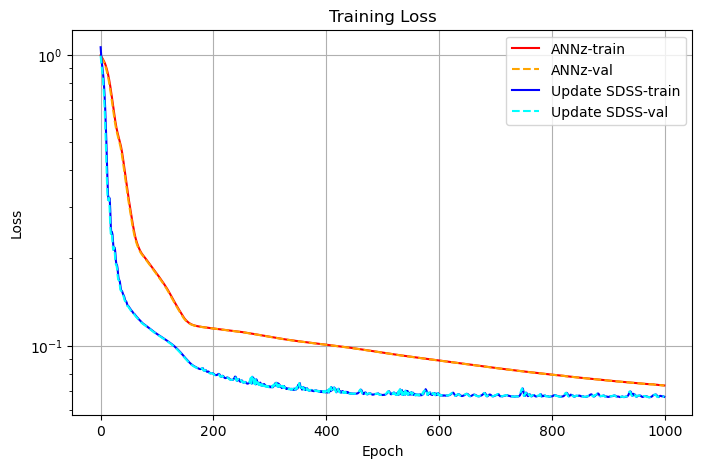


Final loss: 0.073035
Final loss: 0.066805


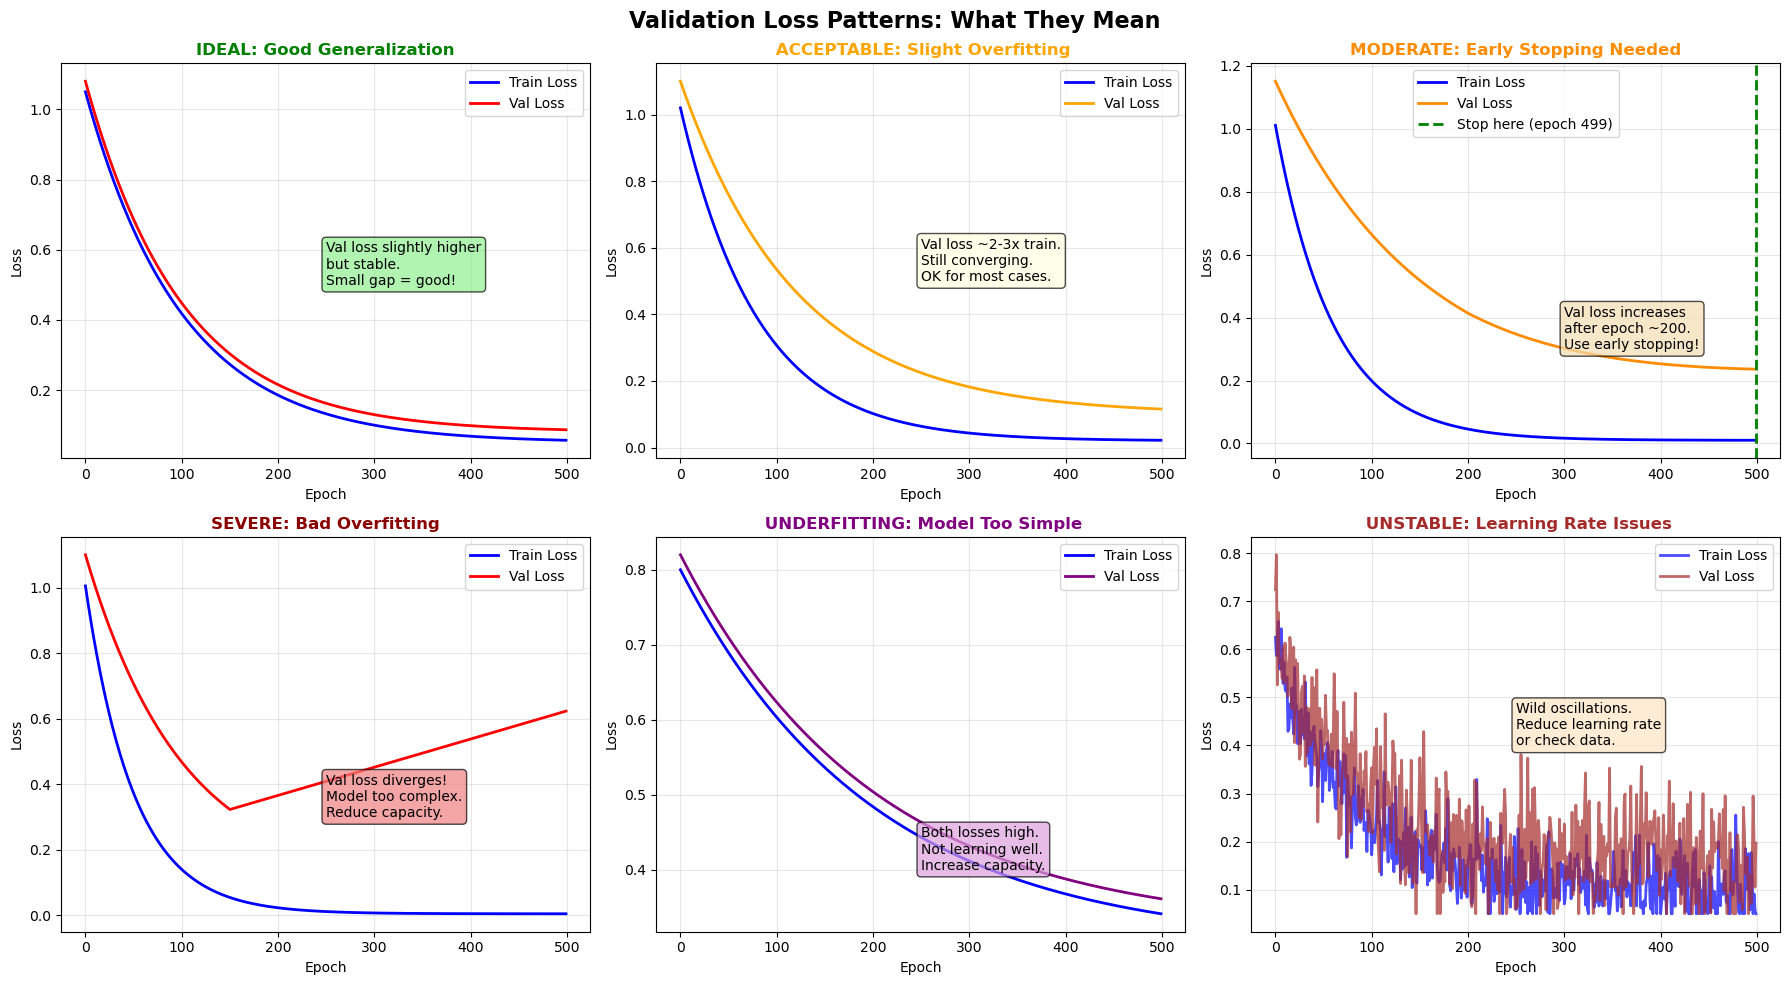

VALIDATION LOSS PATTERNS - QUICK REFERENCE

✅ IDEAL:
   - Val loss slightly > train loss (1.2-1.5x)
   - Both decrease smoothly
   - Val loss plateaus at similar level to train
   - Small gap remains constant

⚠️ ACCEPTABLE (Slight Overfitting):
   - Val loss 2-3x train loss
   - Both still decreasing
   - Gap widens slowly
   - Solution: Train a bit longer, add slight regularization

⚠️ MODERATE (Early Stopping Needed):
   - Val loss decreases then increases
   - Train loss continues to decrease
   - Clear divergence point visible
   - Solution: Use early stopping at minimum val loss

❌ SEVERE (Bad Overfitting):
   - Val loss >> train loss (5-30x or more)
   - Val loss increases significantly over time
   - Train loss very low
   - Solution: Reduce model size, add dropout, stronger regularization

❌ UNDERFITTING:
   - Both losses high and similar
   - Little to no gap
   - Both plateau at high values
   - Solution: Increase model capacity, train longer, reduce regularization

❌ UNSTAB

In [58]:
# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(range(len(losses_ANNz)), losses_ANNz, label='ANNz-train', c = 'r')
plt.plot(range(len(val_losses_ANNz)), val_losses_ANNz, label='ANNz-val', c = 'orange', ls = '--')

plt.plot(range(len(losses_update_SDSS)),losses_update_SDSS, label='Update SDSS-train', c = 'b')
plt.plot(range(len(val_losses_update_SDSS)),val_losses_update_SDSS, label='Update SDSS-val', c = 'cyan', ls = '--')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.show()

print(f"\nFinal loss: {losses_ANNz[-1]:.6f}")
print(f"Final loss: {losses_update_SDSS[-1]:.6f}")

#If you are not familar of reading training and validation loss, 
# here is a VALIDATION LOSS PATTERNS - QUICK REFERENCE guide you could call

import val_loss_reference_guide
val_loss_reference_guide.load_guide()

### Test and Predict

In [60]:
### work with test data

data_test = Table.read('../example_data/sdss/sdss.ugriz.test', format = 'ascii')
input_data_x_test = np.array(data_val['col1', 'col2','col3','col4','col5'].to_pandas()) #ugriz photometry, from ANNz readme
input_data_y_test = np.array(data_val['col11']).astype('float64') #redshift


x_test_tensor =  torch.tensor(transform_val_or_test(input_data_x_test,scaler_x),dtype=torch.float32)

def predict(model, x_test_tensor, input_data_y_test ):
      
      model.eval()
      with torch.no_grad():
            y_pred = model(x_test_tensor).numpy().flatten()
            y_real_value = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
            L2_error = np.sqrt(np.mean(((input_data_y_test -y_real_value.flatten())**2)))

      return y_pred, y_real_value, L2_error



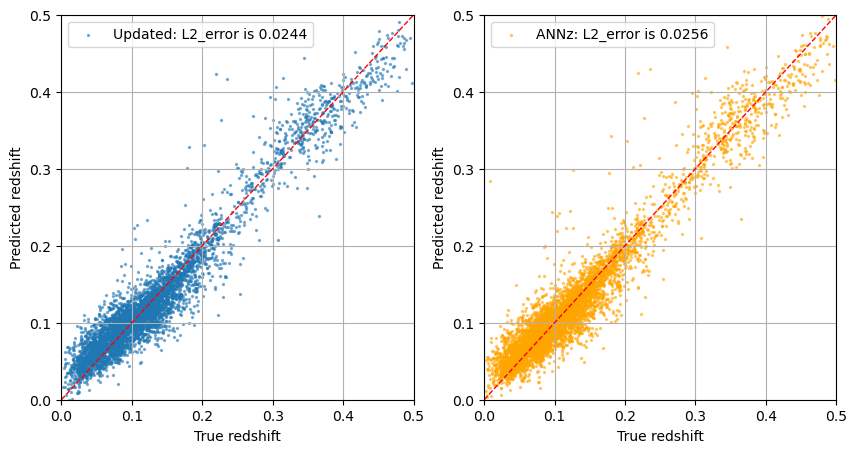

In [63]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))

model  = model_update_SDSS
y_pred, y_real_value, L2_error = predict(model, x_test_tensor, input_data_y_test )

ax = axs[0]
ax.scatter(input_data_y_test, y_real_value, s = 2, label = f'Updated: L2_error is {round(L2_error,4)}', alpha = 0.5)
ax.plot([0,1],[0,1], lw = 1, ls = '--', c = 'r')
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.5)
ax.set_xlabel('True redshift')
ax.set_ylabel('Predicted redshift')


ax.legend()
ax.grid()

ax = axs[1]

model  = model_ANNz
y_pred, y_real_value, L2_error = predict(model, x_test_tensor, input_data_y_test )

ax.scatter(input_data_y_test, y_real_value, s = 2, label = f'ANNz: L2_error is {round(L2_error,4)}', c = 'orange', alpha = 0.5)
ax.plot([0,1],[0,1], lw = 1, ls = '--', c = 'r')
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.5)
ax.set_xlabel('True redshift')
ax.set_ylabel('Predicted redshift')


ax.legend()
ax.grid()

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(range(len(losses_ANNz)), losses_ANNz, label='ANNz-train', c = 'r')
plt.plot(range(len(val_losses_ANNz)), val_losses_ANNz, label='ANNz-val', c = 'orange', ls = '--')

plt.plot(range(len(losses_update_SDSS)),losses_update_SDSS, label='Update SDSS-train', c = 'b')
plt.plot(range(len(val_losses_update_SDSS)),val_losses_update_SDSS, label='Update SDSS-val', c = 'cyan', ls = '--')

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.show()

print(f"\nFinal loss: {losses_ANNz[-1]:.6f}")
print(f"Final loss: {losses_update_SDSS[-1]:.6f}")

In [ ]:

from astropy.table import Table, hstack, vstack
from astropy.io import fits
import urllib.request
import io
import gzip